# Tiny Imagenet Dataset with Resnet18 

The goal of doing this project was to achieve validation accuracy more than 45% using atleast 5 different types of augmentation. While doing this assignment, the major challenges that I faced are:

1. How to perform data gathering 
2. Understanding the code for resnet
3. Confusion in what should be the shape of the data that needs to be given as input
4. Hyper parameter optimization
5. Choosing the right image augmentation techniques that helped me to reach the required accuracy


In [0]:
'''
Importing the required libraries to work with. 
'''

from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import six

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Activation, Flatten, GlobalAveragePooling2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger

import os

from scipy.misc import imread
import scipy.misc

import tensorflow as tf

Using TensorFlow backend.


In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        conv_layer = Conv2D(num_outputs, (1, 1), kernel_initializer="he_normal",
                      activation="softmax")(pool2)
        output = GlobalAveragePooling2D()(conv_layer)
        

        model = Model(inputs=input, outputs=output)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
!ls

sample_data


In [0]:
## Download the dataset and unzip it everytime the session crashes.
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-04-10 06:52:00--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.7MB/s    in 15s     

2019-04-10 06:52:20 (16.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
## Skip the unzip if unzipped dataset is already present in the directory.
!ls
!unzip -qq 'tiny-imagenet-200.zip'
!ls

sample_data  tiny-imagenet-200.zip
sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


In [0]:
path = os.path.join('tiny-imagenet-200')
print(path)

tiny-imagenet-200


In [0]:
"""
Builds the function loading_data which will help in loading the data having the 
shape as (100000, 64, 64, 3). Also an option has been created to load the data 
with the shape of (100000, 32, 32, 3).
"""

def loading_data(path, resize='False', num_classes=200, dtype=np.float32):

    # Loading the path of the wnids.txt file
    path_for_class_values = os.path.join("wnids.txt")

    # Opening the file 'wnids.txt' and loading all the class values into a list
    with open(os.path.join(path, path_for_class_values), 'r') as file:
        class_values = [x.strip() for x in file]

    # Creating a dictionary with numbers assigned to each class value
    labelled_class_values = {class_name:i for i, class_name in enumerate(class_values)}

    # Loading the path of the words.txt file
    path_for_classes = os.path.join('words.txt')

    # Opening the file 'words.txt' and loading all the values into a dictionary
    # with the dictionary key as the class value and the dictionary value contains
    # the class name for that particular class value
    with open(os.path.join(path, path_for_classes), 'r') as file:
        value_to_name = dict(line.split('\t') for line in file)

    # Converting the values present in the class_value_to_name dictionary
    # to lists so that we can get all the values if there are multiple answers
    for value, name in value_to_name.items():
        value_to_name[value] = [value.strip() for w in name.split(',')]


    # Create a list with only the class names 
    class_names = [value_to_name[value] for value in class_values]


    # Creating lists for training data and training target
    xtrain = []
    ytrain = []

    for i, value in enumerate(class_values):

    # Printing that loading of data has completed. It prints after loading 20 files
        if (i+1) % 20 == 0:
            print('loaded training data for network of {}/{}'.format(i+1, len(class_values)))

        # Loading the path of the annotation file for each class folder
        annotation_file = os.path.join(path, 'train', value, '{}_boxes.txt'.format(value))

        # Creating a list with all the names of the images for a particular class
        with open(annotation_file, 'r') as file:
            filenames = [x.split('\t')[0] for x in file]

        # Getting the total number of images in the each class folder
        num_images = len(filenames)

        # Resizing the image if the parameter resize is True else leaving it as is
        if resize == True:
            xtrain_block = np.zeros((num_images, 3, 32, 32), dtype=dtype)
        else:
            xtrain_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)

        # Creating a matrix for ytrain
        ytrain_block = labelled_class_values[value] * np.ones(num_images, dtype=np.int64)

        # Changing the parameter of all the images in a given class file
        for j, image_file in enumerate(filenames):
            image_file = os.path.join(path, 'train', value, 'images', image_file)

            # Reading the image
            image = imread(image_file)

            # Resizing the image
            if resize == True:
                image = scipy.misc.imresize(image, (32, 32, 3))

            # Checking for Grey Scale Image
            if image.ndim == 2:
                if resize == True:
                    image.shape = (32, 32, 1)
                else:
                    image.shape = (64, 64, 1)

            # Loading the value of the image to the particular index
            xtrain_block[j] = image.transpose(2, 0, 1)

        # Appending values of xtrain_blocks and ytrain_blocks
        xtrain.append(xtrain_block)
        ytrain.append(ytrain_block)

  # Concatenating all the values present in xtrain and ytrain
    xtrain = np.concatenate(xtrain, axis=0)
    ytrain = np.concatenate(ytrain, axis=0)

  # Open the file of validation dataset
    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        image_files = []
        val_values = []
        for line in f:
      # Select only validation images in chosen values set
            if line.split()[1] in class_values:
                image_file, value = line.split('\t')[:2]
                image_files.append(image_file)
                val_values.append(value)
    num_val = len(image_files)
    yval = np.array([labelled_class_values[value] for value in val_values])

    if resize == True:
        xval = np.zeros((num_val, 3, 32, 32), dtype=dtype)
    else:
        xval = np.zeros((num_val, 3, 64, 64), dtype=dtype)

    for i, image_file in enumerate(image_files):
        image_file = os.path.join(path, 'val', 'images', image_file)
        img = imread(image_file)
        if resize == True:
            img = scipy.misc.imresize(img, (32, 32, 3))
        if img.ndim == 2:
            if resize == True:
                img.shape = (32, 32, 1)
            else:
                img.shape = (64, 64, 1)

        xval[i] = img.transpose(2, 0, 1)


    return class_names, xtrain, ytrain, xval, yval

In [0]:
def process_images(num_classes=200):
	# Path to tiny imagenet dataset
	#path = input('Enter the relative path to the directory containing the wnids/words files: ')
	path = os.path.join('tiny-imagenet-200')
	#path = os.path.join('tiny-imagenet-200', 'random', '0')
	print(path)
	# Generate data fields - test data has no labels so ignore it
	classes, xtrain, ytrain, xval, yval = loading_data(path, resize=False)
	# Get number of classes specified in order from [0, num_classes)
	print(classes)
	
	#print(xtrain)
	print(xtrain.shape)
	print('xtrain', xtrain[0], sep='\n')
	
	print(ytrain.shape)
	print('ytrain', ytrain, sep='\n')
	
	# Format data to be the correct shape
	xtrain = np.einsum('iljk->ijkl', xtrain)
	print('xtrain', xtrain[0], sep='\n')
	
	xval = np.einsum('iljk->ijkl', xval)
	

	# Convert labels to one hot vectors
	ytrain = keras.utils.to_categorical(ytrain, num_classes)
	print('ytrain', ytrain, sep='\n')
	
	yval = keras.utils.to_categorical(yval, num_classes)

	return xtrain, ytrain, xval, yval

In [0]:
xtrain, ytrain, xval, yval = process_images()

tiny-imagenet-200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loaded training data for network of 20/200
loaded training data for network of 40/200
loaded training data for network of 60/200
loaded training data for network of 80/200
loaded training data for network of 100/200
loaded training data for network of 120/200
loaded training data for network of 140/200
loaded training data for network of 160/200
loaded training data for network of 180/200
loaded training data for network of 200/200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[['n02124075'], ['n04067472'], ['n04540053'], ['n04099969', 'n04099969'], ['n07749582'], ['n01641577', 'n01641577'], ['n02802426'], ['n09246464', 'n09246464', 'n09246464'], ['n07920052'], ['n03970156', 'n03970156'], ['n03891332'], ['n02106662', 'n02106662', 'n02106662', 'n02106662'], ['n03201208', 'n03201208'], ['n02279972', 'n02279972', 'n02279972', 'n02279972'], ['n02132136', 'n02132136', 'n02132136'], ['n04146614'], ['n07873807', 'n07873807'], ['n02364673', 'n02364673'], ['n04507155'], ['n03854065', 'n03854065'], ['n03838899', 'n03838899', 'n03838899'], ['n03733131'], ['n01443537', 'n01443537'], ['n07875152'], ['n03544143'], ['n09428293', 'n09428293', 'n09428293', 'n09428293'], ['n03085013', 'n03085013'], ['n02437312', 'n02437312', 'n02437312'], ['n07614500', 'n07614500'], ['n03804744'], ['n04265275'], ['n02963159'], ['n02486410'], ['n01944390'], ['n09256479'], ['n02058221', 'n02058221'], ['n04275548', 'n04275548'], ['n02321529', 'n02321529'], ['n02769748', 'n02769748', 'n02769748',

In [0]:
"""
Creating callback objects 
1. ReduceLROnPlateau
2. CSVLogger
"""
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger('resnet18_tiny_imagenet.csv')

In [0]:
"""
Setting the hyperparameter values
"""
nb_classes = 200
nb_epoch = 60
data_augmentation = True
batch_size = 512

"""
Setting image size: There are two choices...
1. 32 x 32
2. 64 x 64
"""
img_rows, img_cols = 64, 64
img_channels = 3

In [0]:
xtrain = xtrain.astype('float32')
xval = xval.astype('float32')

(100000, 64, 64, 3)


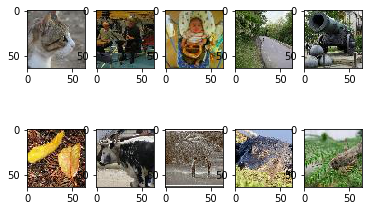

In [0]:
"""
Printing 10 images in a subplot. 
"""
print (xtrain.shape)

fig, ax = plt.subplots(nrows=2, ncols=5)

i = 0

for row in ax:
	for col in row:
		if i < 100000:
			col.imshow(xtrain[i].astype(int))
			i += 10000

In [0]:
"""
Reshaping the xtrain and xval data to the range of 0 and 1.
"""
xtrain /= 255.
xval /= 255.

In [0]:
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
"""
Using ImageDataGenerator Class from perform image augmentation. Here there are 5 types 
of augmentation that are performed. 

These were chosen as they gave the best validation accuracy.
"""
datagen = ImageDataGenerator(
        rotation_range=0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)
datagen.fit(xtrain)

In [0]:
"""
Two options to train a model. 
1. Without data augmentation
2. with real-time data augmentation
"""
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(xtrain, ytrain,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(xval, yval),
              shuffle=True,
              callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                        steps_per_epoch=xtrain.shape[0] // batch_size,
                        validation_data=(xval, yval),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        shuffle = True,
                        callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=195, validation_data=(array([[[..., epochs=60, verbose=1, shuffle=True, callbacks=[<keras.ca..., max_queue_size=100)`


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/60
195/195 [==============================] - 155s 796ms/step - loss: 5.1327 - acc: 0.0958 - val_loss: 5.9005 - val_acc: 0.0411
Epoch 2/60
195/195 [==============================] - 145s 745ms/step - loss: 4.2458 - acc: 0.1798 - val_loss: 4.4626 - val_acc: 0.1447
Epoch 3/60
195/195 [==============================] - 146s 746ms/step - loss: 3.9231 - acc: 0.2195 - val_loss: 4.3651 - val_acc: 0.1607
Epoch 4/60
195/195 [==============================] - 146s 747ms/step - loss: 3.7159 - acc: 0.2504 - val_loss: 4.0536 - val_acc: 0.1982
Epoch 5/60
195/195 [==============================] - 146s 748ms/step - loss: 3.5622 - acc: 0.2761 - val_loss: 3.9758 - val_acc: 0.2099
Epoch 6/60
195/195 [==============================] - 146s 751ms/step - loss: 3.4446 - acc: 0.2963 - val_loss: 3.9069 - val_acc: 0.2212
Epoch 7/60
195/195 [==============================] - 146s

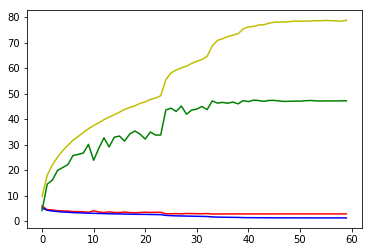

In [0]:
plt.plot(history.epoch, history.history['val_loss'],'r',
        history.epoch, history.history['loss'],'b',
        history.epoch, np.dot(history.history['val_acc'], 100),'g',
        history.epoch, np.dot(history.history['acc'], 100),'y')

This ends the training of the model. 

Here as you can observe, the **highest validation accuracy ** is: 47.43

The validation accuracy plateaued after 40+ epochs but the training accuracy kept increasing. I've used 5 different types of data augmentation which are: 
1. Rotation Range
2. Width Shift Range
3. Height Shift Range
4. Horizontal Flip
5. Vertical Flip

Also, I tried with Cyclic Learning rate. There the accuracy was changing randomly. I was not able to understand how to implement Cyclic Learning Rate. So, I dropped it and ran the model with RLROP. 

In [0]:
!ls

resnet18_tiny_imagenet.csv  tiny-imagenet-200
sample_data		    tiny-imagenet-200.zip


In [0]:
df = pd.read_csv('resnet18_tiny_imagenet.csv')

In [0]:
df

,epoch,acc,loss,lr,val_acc,val_loss
0,0,0.095753,5.132717,1.000000e-03,0.0411,5.900537
1,1,0.180012,4.244963,1.000000e-03,0.1447,4.462647
2,2,0.219645,3.922100,1.000000e-03,0.1607,4.365125
3,3,0.250472,3.715632,1.000000e-03,0.1982,4.053575
4,4,0.276104,3.562374,1.000000e-03,0.2099,3.975808
5,5,0.296327,3.444243,1.000000e-03,0.2212,3.906919
6,6,0.317345,3.329456,1.000000e-03,0.2571,3.719311
7,7,0.331598,3.249004,1.000000e-03,0.2614,3.707181
8,8,0.347147,3.167797,1.000000e-03,0.2668,3.664445
9,9,0.362255,3.095607,1.000000e-03,0.3007,3.441092


The above data shows the logs of the complete training process which is present in the excel file.